### libraries

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import urllib3
urllib3.disable_warnings()

### data

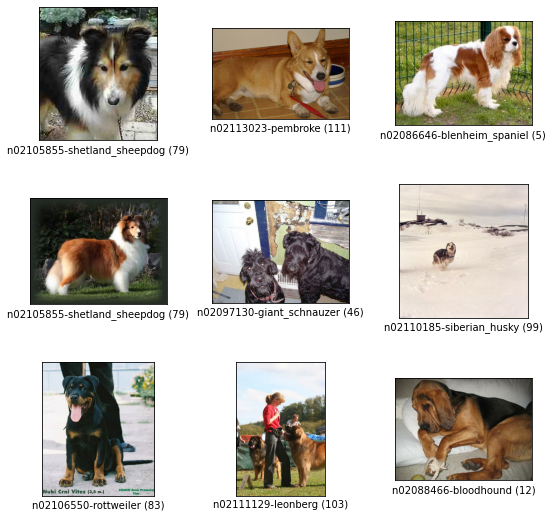

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

fig = tfds.show_examples(ds_train, ds_info)

### 1. Augmentation을 적용한 데이터셋 만들기

In [3]:
# 입력받은 이미지를 0~1 사이의 float32로 normalize하고, (224, 224) 사이즈로 resize하는 전처리 함수

def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [4]:
# 기본 augmentation 함수

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

**cutmix**

In [5]:
# 어떤 크기의 이미지에든 cutmix를 적용할 수 있게 처리하는 함수

def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

In [6]:
# image_a: 바운딩 박스 안, image_b: 바운딩 박스 밖

def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [7]:
# 섞은 두 이미지의 라벨값도 비율에 맞게 합쳐주는 함수

def mix_2_label(image_a, image_b, label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

In [8]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(image_a, image_b, label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

**mixup**

In [9]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

In [10]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [11]:
# 라벨링을 위한 함수

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [12]:
# normalize_and_resize_img를 적용한 후 augmentation을 적용하는 함수

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup: # mixup을 적용하기 위한 코드 추가
        ds = ds.map(
            mixup, 
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,# ?
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 2. 모델 만들기

**모델 별 데이터셋**

In [13]:
num_classes = ds_info.features["label"].num_classes

In [14]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)

ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)

ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)

ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

In [15]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

aug_cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

aug_mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

### 3. 모델 훈련하기

In [16]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
tf.random.set_seed(2021)

In [17]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [18]:
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 114s 152ms/step - loss: 2.1814 - accuracy: 0.4492 - val_loss: 3.2894 - val_accuracy: 0.2280
Epoch 2/20
750/750 [==============================] - 115s 153ms/step - loss: 0.7831 - accuracy: 0.7793 - val_loss: 1.2771 - val_accuracy: 0.6316
Epoch 3/20
750/750 [==============================] - 115s 153ms/step - loss: 0.3160 - accuracy: 0.9239 - val_loss: 1.0013 - val_accuracy: 0.7076
Epoch 4/20
750/750 [==============================] - 115s 153ms/step - loss: 0.1131 - accuracy: 0.9840 - val_loss: 0.9651 - val_accuracy: 0.7185
Epoch 5/20
750/750 [==============================] - 115s 153ms/step - loss: 0.0562 - accuracy: 0.9944 - val_loss: 0.9551 - val_accuracy: 0.7299
Epoch 6/20
750/750 [==============================] - 115s 153ms/step - loss: 0.0267 - accuracy: 0.9981 - val_loss: 0.9165 - val_accuracy: 0.7448
Epoch 7/20
750/750 [==============================] - 115s 153ms/step - loss: 0.0173 - accuracy: 0.9990 - val_loss: 0.9280 -

In [19]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
  2/750 [..............................] - ETA: 1:24 - loss: 5.5088 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0531s vs `on_train_batch_end` time: 0.0955s). Check your callbacks.


750/750 [==============================] - 116s 155ms/step - loss: 2.2730 - accuracy: 0.4323 - val_loss: 3.0367 - val_accuracy: 0.2499
Epoch 2/20
750/750 [==============================] - 115s 154ms/step - loss: 0.9489 - accuracy: 0.7278 - val_loss: 1.3918 - val_accuracy: 0.5954
Epoch 3/20
750/750 [==============================] - 117s 156ms/step - loss: 0.5314 - accuracy: 0.8486 - val_loss: 1.2947 - val_accuracy: 0.6364
Epoch 4/20
750/750 [==============================] - 115s 154ms/step - loss: 0.3151 - accuracy: 0.9170 - val_loss: 1.0620 - val_accuracy: 0.6941
Epoch 5/20
750/750 [==============================] - 115s 154ms/step - loss: 0.1578 - accuracy: 0.9672 - val_loss: 0.9896 - val_accuracy: 0.7240
Epoch 6/20
750/750 [==============================] - 115s 154ms/step - loss: 0.0842 - accuracy: 0.9862 - val_loss: 0.9690 - val_accuracy: 0.7359
Epoch 7/20
750/750 [==============================] - 115s 154ms/step - loss: 0.0481 - accuracy: 0.9935 - val_loss: 0.9546 - val_accura

In [20]:
history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
  2/750 [..............................] - ETA: 1:23 - loss: 5.1511 - accuracy: 0.0312WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0527s vs `on_train_batch_end` time: 0.0837s). Check your callbacks.


750/750 [==============================] - 123s 164ms/step - loss: 3.8228 - accuracy: 0.2158 - val_loss: 3.2604 - val_accuracy: 0.2210
Epoch 2/20
750/750 [==============================] - 123s 164ms/step - loss: 2.9642 - accuracy: 0.4186 - val_loss: 1.4271 - val_accuracy: 0.6060
Epoch 3/20
750/750 [==============================] - 122s 163ms/step - loss: 2.6690 - accuracy: 0.5253 - val_loss: 1.3103 - val_accuracy: 0.6431
Epoch 4/20
750/750 [==============================] - 120s 161ms/step - loss: 2.4510 - accuracy: 0.5920 - val_loss: 1.2856 - val_accuracy: 0.6435
Epoch 5/20
750/750 [==============================] - 120s 161ms/step - loss: 2.3069 - accuracy: 0.6367 - val_loss: 1.1386 - val_accuracy: 0.6844
Epoch 6/20
750/750 [==============================] - 120s 160ms/step - loss: 2.1791 - accuracy: 0.6808 - val_loss: 1.3384 - val_accuracy: 0.6367
Epoch 7/20
750/750 [==============================] - 120s 160ms/step - loss: 2.1038 - accuracy: 0.7047 - val_loss: 1.1252 - val_accura

In [21]:
history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
  2/750 [..............................] - ETA: 1:20 - loss: 5.3160 - accuracy: 0.0312    WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0482s vs `on_train_batch_end` time: 0.0823s). Check your callbacks.


750/750 [==============================] - 121s 161ms/step - loss: 3.7705 - accuracy: 0.2338 - val_loss: 5.6360 - val_accuracy: 0.0484
Epoch 2/20
750/750 [==============================] - 120s 160ms/step - loss: 2.8990 - accuracy: 0.4660 - val_loss: 1.5109 - val_accuracy: 0.5760
Epoch 3/20
750/750 [==============================] - 120s 160ms/step - loss: 2.6334 - accuracy: 0.5641 - val_loss: 1.3529 - val_accuracy: 0.6212
Epoch 4/20
750/750 [==============================] - 120s 160ms/step - loss: 2.4157 - accuracy: 0.6450 - val_loss: 1.2560 - val_accuracy: 0.6461
Epoch 5/20
750/750 [==============================] - 120s 160ms/step - loss: 2.3008 - accuracy: 0.6870 - val_loss: 1.2745 - val_accuracy: 0.6549
Epoch 6/20
750/750 [==============================] - 121s 161ms/step - loss: 2.1910 - accuracy: 0.7304 - val_loss: 1.3811 - val_accuracy: 0.6333
Epoch 7/20
750/750 [==============================] - 122s 163ms/step - loss: 2.1163 - accuracy: 0.7531 - val_loss: 1.2617 - val_accura

In [22]:
history_resnet50_aug_cutmix = aug_cutmix_resnet50.fit(
    ds_train_aug_cutmix, # augmentation + cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
  2/750 [..............................] - ETA: 1:22 - loss: 5.2121 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0523s vs `on_train_batch_end` time: 0.0817s). Check your callbacks.


750/750 [==============================] - 121s 162ms/step - loss: 3.8534 - accuracy: 0.2034 - val_loss: 2.9421 - val_accuracy: 0.2733
Epoch 2/20
750/750 [==============================] - 121s 161ms/step - loss: 3.0165 - accuracy: 0.4075 - val_loss: 1.5790 - val_accuracy: 0.5752
Epoch 3/20
750/750 [==============================] - 121s 161ms/step - loss: 2.7665 - accuracy: 0.4913 - val_loss: 1.4983 - val_accuracy: 0.5972
Epoch 4/20
750/750 [==============================] - 121s 161ms/step - loss: 2.5564 - accuracy: 0.5433 - val_loss: 1.3457 - val_accuracy: 0.6240
Epoch 5/20
750/750 [==============================] - 121s 161ms/step - loss: 2.4425 - accuracy: 0.5883 - val_loss: 1.1851 - val_accuracy: 0.6664
Epoch 6/20
750/750 [==============================] - 121s 161ms/step - loss: 2.3337 - accuracy: 0.6226 - val_loss: 1.1252 - val_accuracy: 0.6908
Epoch 7/20
750/750 [==============================] - 121s 161ms/step - loss: 2.2388 - accuracy: 0.6533 - val_loss: 1.1530 - val_accura

In [23]:
history_resnet50_aug_mixup = aug_mixup_resnet50.fit(
    ds_train_aug_mixup, # augmentation + mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
  2/750 [..............................] - ETA: 1:25 - loss: 5.2549 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0569s vs `on_train_batch_end` time: 0.0864s). Check your callbacks.


750/750 [==============================] - 122s 162ms/step - loss: 3.7591 - accuracy: 0.2315 - val_loss: 3.5563 - val_accuracy: 0.1903
Epoch 2/20
750/750 [==============================] - 121s 162ms/step - loss: 2.9475 - accuracy: 0.4532 - val_loss: 1.6234 - val_accuracy: 0.5521
Epoch 3/20
750/750 [==============================] - 122s 162ms/step - loss: 2.6951 - accuracy: 0.5370 - val_loss: 1.3934 - val_accuracy: 0.6073
Epoch 4/20
750/750 [==============================] - 122s 162ms/step - loss: 2.5232 - accuracy: 0.6014 - val_loss: 1.4401 - val_accuracy: 0.6014
Epoch 5/20
750/750 [==============================] - 128s 171ms/step - loss: 2.3889 - accuracy: 0.6462 - val_loss: 1.3679 - val_accuracy: 0.6194
Epoch 6/20
750/750 [==============================] - 121s 162ms/step - loss: 2.2967 - accuracy: 0.6816 - val_loss: 1.2605 - val_accuracy: 0.6613
Epoch 7/20
750/750 [==============================] - 121s 161ms/step - loss: 2.1787 - accuracy: 0.7265 - val_loss: 1.2839 - val_accura

### 4. 훈련 과정 시각화하기

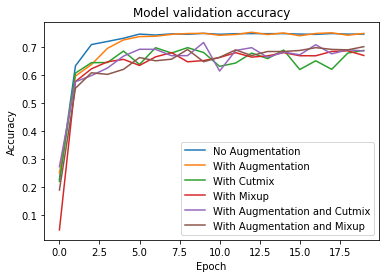

In [28]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'tab:blue')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'tab:orange')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'tab:green')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'tab:red')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'tab:purple')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'tab:brown')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup', 'With Augmentation and Cutmix', 'With Augmentation and Mixup'], loc='lower right')
plt.show()

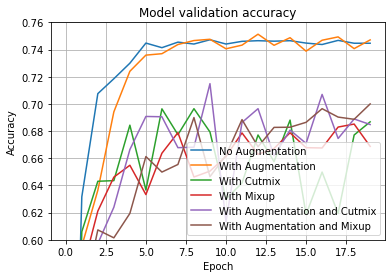

In [30]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'tab:blue')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'tab:orange')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'tab:green')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'tab:red')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'tab:purple')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'tab:brown')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup', 'With Augmentation and Cutmix', 'With Augmentation and Mixup'], loc='lower right')
plt.grid(True)
plt.ylim(0.60, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

### 5. Augmentation에 의한 모델 성능 비교

위의 시각화 결과를 보면 알 수 있듯, 기본적인 augmentation만 적용하거나 augmentation을 적용하지 않은 데이터셋을 활용했을 때 더 좋은 성능을 냈고, cutmix나 mixup을 사용하거나 거기에 기본 augmentation을 함께 사용한 경우엔 정확도가 상대적으로 낮게 나왔다.

### 회고

augmentation을 접할 때마다 드는 생각은 결국 어떤 아이디어로, 어떤 방식의 augmentation을 적용해야 하는지에 대해 정해진 것이 없다는 것이다.   
이번에 사용한 데이터셋에는 cutmix나 mixup 방식을 적용해도 모델의 성능이 향상되지 않았지만, 이 방식들로 모델의 성능을 향상시킬 수 있는 적절한 데이터셋 또한 존재할 것이다.   
결국 모델 성능의 향상을 위해 augmentation을 적용할 땐 여러 가지 아이디어를 가지고 여러 시도를 해보는 것이 중요한 것 같다.